# Predicting Landslides in Oregon
## Reed Laverack, February 2016


In [47]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from time import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

Load Data Frames

In [48]:
X = pd.read_csv("X_whole.csv")
y = pd.read_csv("y_whole.csv").pop('SLIDE')

Split into training and testing sets with the training set comprising of 30%

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

Load Random forest classifier, fit it to the training set and use it to predict on the testing set. 

In [50]:
clf = RandomForestClassifier(n_estimators=1000,min_samples_split=5)

In [52]:
t0 = time()
clf.fit(X_train, y_train)
print ("Training time:", round(time() - t0, 3), "s")


('Training time:', 3.723, 's')


In [14]:
#Predict on test set
t1 = time()
pred = clf.predict(X_test)
print ("predicting time:", round(time() - t1, 3), "s")


('predicting time:', 0.445, 's')


In [15]:
accuracy_score(pred, y_test)

0.83698630136986296

Find the feature importances in the decision tree

In [16]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
features = pd.DataFrame(list(X))

In [17]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d : %s : (%f)" % (f + 1, indices[f], features[0][indices[f]], importances[indices[f]]))


Feature ranking:
1. feature 0 : Slope : (0.138488)
2. feature 48 : COVERAGE_Developed, Open : (0.105309)
3. feature 2 : Precip_Mon : (0.066014)
4. feature 3 : Soil_Moist : (0.060670)
5. feature 6 : Soil_Temp : (0.057412)
6. feature 5 : Vegetation : (0.056137)
7. feature 4 : Soil_Moist_Depth : (0.053907)
8. feature 8 : maxtempi : (0.048984)
9. feature 9 : mintempi : (0.044240)
10. feature 11 : maxpressurei : (0.043753)
11. feature 7 : maxwspdi : (0.040069)
12. feature 10 : maxhumidity : (0.035390)
13. feature 49 : COVERAGE_Evergreen Forest : (0.034618)
14. feature 55 : COVERAGE_Shrub : (0.032402)
15. feature 46 : COVERAGE_Developed, Low : (0.021988)
16. feature 1 : precipi : (0.018138)
17. feature 40 : GEO_GENL_U_volcanic rocks : (0.017602)
18. feature 32 : GEO_GENL_U_marine sedimentary rocks : (0.013950)
19. feature 52 : COVERAGE_Mixed Forest : (0.010286)
20. feature 13 : AGE_NAME_Eocene : (0.009508)
21. feature 37 : GEO_GENL_U_sediments : (0.008745)
22. feature 18 : AGE_NAME_Miocene :

In [18]:
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

/Users/rlaverack/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Investigate incorrect predictions

In [19]:
y_df = pd.DataFrame(y_test).reset_index()
y_df = y_df.rename(columns={0:'SLIDE'})

In [20]:
pred_df = pd.DataFrame(pred)

In [21]:
X_test = X_test.reset_index()

In [22]:
frames = [X_test,y_df,pred_df]
answers = pd.concat(frames,axis=1)

In [23]:
wrong_answers = answers[answers['SLIDE'] != answers[0]]

In [53]:
pred = clf.predict_proba(X_test)
pred_df = pd.DataFrame(pred)

In [28]:
frames = [X_test,y_df,pred_df]
answers = pd.concat(frames,axis=1)

In [29]:
answers['check'] = np.where(answers[1]>0.3, 1, 0)

In [30]:
check = answers.pop('check')

In [ ]:
wrong_answers = answers[answers['SLIDE'] != answers['check']]

In [ ]:
wrong_answers['check'].value_counts()

In [ ]:
wrong_answers['check'].describe()

In [87]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [55]:
pos_pred = [i[1] for i in pred]

In [56]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, pos_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

In [57]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [58]:
neg_pred = [i[0] for i in pred]

In [73]:
neg_test = [1 - i for i in y_test]

In [84]:
false_negative_rate, true_negative_rate, thresholds = roc_curve(neg_test, neg_pred)
roc_auc = auc(false_negative_rate, true_negative_rate)

In [85]:
false_negative_rate = false_negative_rate * 100
true_negative_rate = true_negative_rate * 100
roc_auc = roc_auc *100

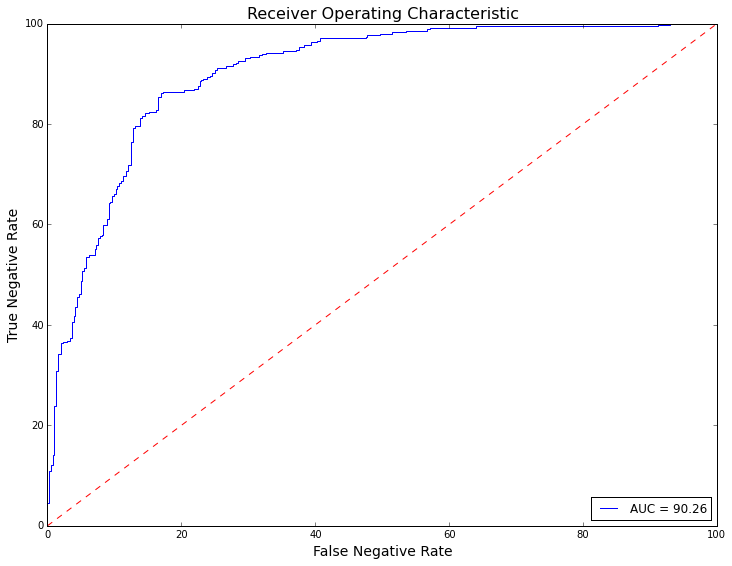

In [95]:
fig = plt.figure(figsize=(12, 9)) 
ax = plt.subplot(111)
plt.title('Receiver Operating Characteristic',fontsize=16)
ax.plot(false_negative_rate, true_negative_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,100],[0,100],'r--')
plt.xlim([-0.0,100])
plt.ylim([-0.0,100])
plt.ylabel('True Negative Rate',fontsize=14)
plt.xlabel('False Negative Rate',fontsize=14)

In [83]:
true_negative_rate

array([    28.8184438 ,     57.63688761,     86.45533141,    115.27377522,
          172.91066282,    230.54755043,    259.36599424,    288.18443804,
          317.00288184,    345.82132565,    374.63976945,    403.45821326,
          432.27665706,    461.09510086,    461.09510086,    489.91354467,
          518.73198847,    547.55043228,    576.36887608,    605.18731988,
          634.00576369,    662.82420749,    691.6426513 ,    720.4610951 ,
          749.2795389 ,    778.09798271,    806.91642651,    835.73487032,
          864.55331412,    893.37175793,    922.19020173,    951.00864553,
          979.82708934,   1008.64553314,   1037.46397695,   1066.28242075,
         1095.10086455,   1095.10086455,   1123.91930836,   1152.73775216,
         1181.55619597,   1210.37463977,   1210.37463977,   1239.19308357,
         1268.01152738,   1296.82997118,   1325.64841499,   1354.46685879,
         1383.28530259,   1412.1037464 ,   1412.1037464 ,   1440.9221902 ,
         1498.55907781,  